# 1. Import libraries

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix, roc_curve
%matplotlib notebook
import joblib

# 2. Import dataset

The Kaggle dataset contains information of the sellers (and customers) of a C2C e-commerce website. To make this dataset suitable for our analysis, the raw dataset was cleaned, and the "fraud" column is added as a target variable with two unique values (1 for fraudulent sales activity, 0 otherwise) (A sale has been termed to be fraud if the sent product mismatches the product description at the verification process before shipping.)

In [2]:
# Import raw data from kaggle
data = pd.read_csv('raw_data.csv')
data

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,...,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-1097895247965112460,user,Royaume-Uni,en,147,10,77,26,174,74.0,...,mr,True,False,True,True,11,3196,106.53,8.88,gb
1,2347567364561867620,user,Monaco,en,167,8,2,19,170,99.0,...,mrs,True,False,True,True,12,3204,106.80,8.90,mc
2,6870940546848049750,user,France,fr,137,13,60,33,163,94.0,...,mrs,True,False,True,False,11,3203,106.77,8.90,fr
3,-4640272621319568052,user,Etats-Unis,en,131,10,14,122,152,92.0,...,mrs,True,False,True,False,12,3198,106.60,8.88,us
4,-5175830994878542658,user,Etats-Unis,en,167,8,0,25,125,100.0,...,mrs,False,False,False,True,22,2854,95.13,7.93,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,-5324380437900495747,user,Etats-Unis,fr,3,8,0,0,0,0.0,...,mr,False,False,False,True,708,3204,106.80,8.90,us
98909,-5607668753771114442,user,France,fr,3,8,0,0,0,0.0,...,mr,True,False,True,True,695,3204,106.80,8.90,fr
98910,350630276238833248,user,Belgique,en,3,8,0,0,0,0.0,...,mr,True,True,False,True,520,3204,106.80,8.90,be
98911,2006580738726207028,user,Italie,it,3,8,0,0,0,0.0,...,mrs,False,False,False,True,267,3204,106.80,8.90,it


In [3]:
# Get variables in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  int64  
 1   type                 98913 non-null  object 
 2   country              98913 non-null  object 
 3   language             98913 non-null  object 
 4   socialNbFollowers    98913 non-null  int64  
 5   socialNbFollows      98913 non-null  int64  
 6   socialProductsLiked  98913 non-null  int64  
 7   productsListed       98913 non-null  int64  
 8   productsSold         98913 non-null  int64  
 9   productsPassRate     98913 non-null  float64
 10  productsWished       98913 non-null  int64  
 11  productsBought       98913 non-null  int64  
 12  gender               98913 non-null  object 
 13  civilityGenderId     98913 non-null  int64  
 14  civilityTitle        98913 non-null  object 
 15  hasAnyApp            98913 non-null 

There are 24 variables in the dataset. Not all are relevant and there are categorical data type

# 3. Feature Engineering

Feature Engineering is the process of transforming raw data into useful features that help us to understand our model better and increase its predictive power. 

Since shopee deactivates inactive shops within 90 days, https://seller.shopee.sg/edu/article/18517/deactivated-inactive-shop, we need to rescale data

In [4]:
# Drop irrelevant columns, not applicable to shopee
data.drop(['identifierHash','type','country','language','civilityTitle','hasAnyApp','gender','civilityGenderId','seniorityAsMonths','seniorityAsYears','countryCode','hasAndroidApp','hasIosApp', 'productsWished', 'productsBought'],axis=1,inplace=True)

In [5]:
# Add new columns for no of products passed and products failed
for i in data.index:
    case_no = data.loc[i,'productsSold']
    pass_no = round((case_no * data.loc[i,'productsPassRate']) / 100)
    fail_no = case_no - pass_no
    data.loc[i,'productsPassed'] = pass_no
    data.loc[i,'productsFailed'] = fail_no
    
    # normalise daysSinceLastLogin to range between 0 and 90
    min_days = min(data['daysSinceLastLogin'])
    max_days = max(data['daysSinceLastLogin'])
    range_days = max_days - min_days
    _daysSinceLastLogin = round(((data.loc[i,'daysSinceLastLogin'] - min_days) * 90) / range_days)
    data.loc[i,'_daysSinceLastLogin'] = _daysSinceLastLogin
    
    # Drop rows with no products sold as we cannot determine fradulence iow may be new seller
    if case_no == 0:
        data.drop(i, axis=0,inplace=True) 
    
data.drop(['productsPassRate', 'productsSold', 'daysSinceLastLogin'], axis=1,inplace=True)

In [6]:
# Encode categorical variable ('True', 'False') to numerical values
Encodedict={}
key='_{}'.format('hasProfilePicture')
le=LabelEncoder()
data[key]=le.fit_transform(list(data['hasProfilePicture']))
Encodedict[key]=le.classes_                          
data.drop(['hasProfilePicture'],axis=1,inplace=True)

In [7]:
# Determine 'Fraud' value based on productsPassed and productsFailed
indices = data.index
dfdict = {}
for j in indices:
    pp = data.loc[j,'productsPassed']
    pf = data.loc[j,'productsFailed']
    if pp != 0:
        data.loc[j,'Fraud'] = 0 # not fraud
        df = pd.DataFrame(data.loc[j,:]).transpose()
        ldf = pd.concat([df]*int(pp), ignore_index=True) # Replicate data pp time
    
    if pf != 0:
        data.loc[j,'Fraud'] = 1 # fraud
        df2 = pd.DataFrame(data.loc[j,:]).transpose()
        ldf2 = pd.concat([df2]*int(pf), ignore_index=True)
    
    if pp!=0 and pf!=0:
        dfdict[j] = pd.concat([ldf, ldf2],ignore_index=True)
    elif pp!=0:
        dfdict[j] = ldf
    else:
        dfdict[j] = ldf2 

In [8]:
whole_df = pd.concat(dfdict.values(),ignore_index=True)
whole_df.drop(['productsPassed','productsFailed'],axis=1,inplace=True)
whole_df.head()

# Save preprocessed data as new csv file
whole_df.to_csv('modified_data.csv')

# 4. Split data

In [9]:
# Load data
clndf = pd.read_csv('modified_data.csv')

In [10]:
clndf.head()

,Unnamed: 0,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,seniority,_daysSinceLastLogin,_hasProfilePicture,Fraud
0,0,147.0,10.0,77.0,26.0,3196.0,0.0,1.0,0.0
1,1,147.0,10.0,77.0,26.0,3196.0,0.0,1.0,0.0
2,2,147.0,10.0,77.0,26.0,3196.0,0.0,1.0,0.0
3,3,147.0,10.0,77.0,26.0,3196.0,0.0,1.0,0.0
4,4,147.0,10.0,77.0,26.0,3196.0,0.0,1.0,0.0


In [11]:
clndf.describe()

,Unnamed: 0,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,seniority,_daysSinceLastLogin,_hasProfilePicture,Fraud
count,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000
mean,6013.000000,46.023447,170.445664,579.962584,21.243868,3072.820986,8.201796,0.550262,0.226490
std,3472.040178,79.426853,1332.734395,4811.941240,38.379589,166.069121,18.516957,0.497488,0.418577
min,0.000000,3.000000,0.000000,0.000000,0.000000,2852.000000,0.000000,0.000000,0.000000
25%,3006.500000,9.000000,8.000000,1.000000,1.000000,2857.000000,0.000000,0.000000,0.000000
50%,6013.000000,21.000000,8.000000,5.000000,7.000000,3196.000000,0.000000,1.000000,0.000000
75%,9019.500000,52.000000,10.000000,46.000000,23.000000,3201.000000,4.000000,1.000000,0.000000
max,12026.000000,744.000000,13764.000000,51671.000000,244.000000,3205.000000,90.000000,1.000000,1.000000


the ‘Fraud’ column has a mean of 0.22, way lower than 0.5, which indicates that the dataset is imbalanced and biased towards class 0. Let's fix this!

In [12]:
# Delete unnecessary column
clndf.drop(['Unnamed: 0'],axis=1,inplace=True)

In [13]:
# Specify features and target
target_data = clndf['Fraud']
feature_data = clndf.drop(labels = ['Fraud'],axis = 1,inplace = False)

In [14]:
# Perform train-test split
feature_train, feature_test, target_train, target_test = train_test_split(feature_data, target_data, test_size=0.30, random_state=101)
feature_test1, feature_test2, target_test1, target_test2 = train_test_split(feature_test, target_test, test_size=0.40, random_state=101)

# 6. Train model

## 6.1 Hyperparameter Tuning

The code below uses Scikit-Learn’s `GridSearchCV`, which is a technique for finding the optimal parameter values from a given set of parameters in a grid. As we have explicitly defined our scoring metric, grid search will identify the best model based on the optimum AUC score found during its cross-validation process.

The ‘class_weight’ parameter within the paramdict is used to tackle with the class 0 bias of the dataset.

In [15]:
# Creat instance of rf model with default parameters
model = RandomForestClassifier()

# Specify the range of parameters for model_selection module to evaluate
paramdict = {'criterion':['gini','entropy'],'min_samples_leaf':range(4,10),'class_weight':['balanced','balanced_subsample'],'max_features':['sqrt','log2'],'random_state':[101],'min_samples_split':range(2,6),'min_impurity_decrease':list(map(lambda x: x/10, range(0,5,1)))}

# Use grid search to find best hyperparameters
grid = GridSearchCV(model, paramdict, scoring=make_scorer(roc_auc_score),refit=True,verbose=0.2,cv=5,n_jobs=-1)

# Fit grid to training data
grid.fit(feature_train,target_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'min_samples_leaf': range(4, 10),
                         'min_samples_split': range(2, 6),
                         'random_state': [101]},
             scoring=make_scorer(roc_auc_score), verbose=0.2)

In [16]:
# Get optimal param
grid.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'random_state': 101}

All the best parameters here belong to our specified range even excluding their upper and lower limits. So, we may conclude that, this is the best model identified by grid search.

In [17]:
# Save model
joblib.dump(grid, "random_forest.joblib")

['random_forest.joblib']

# 7. Evaluate model

In [18]:
# Load model
loaded_rf = joblib.load("random_forest.joblib")

## 7.1 Visualise the results

In [19]:
rf = loaded_rf.best_estimator_
rf

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features='sqrt', min_samples_leaf=8,
                       random_state=101)

In [20]:
! pip install graphviz

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [21]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

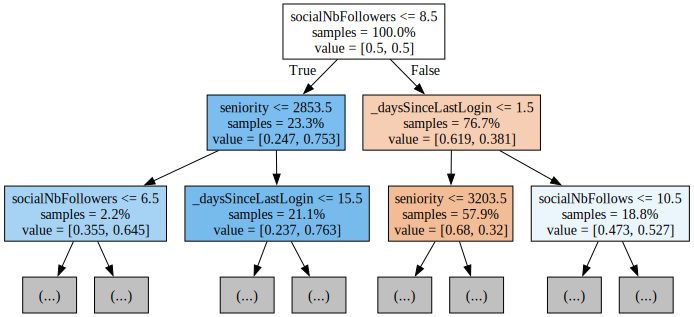

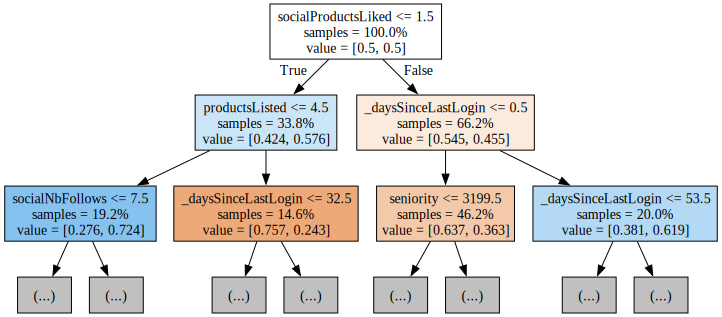

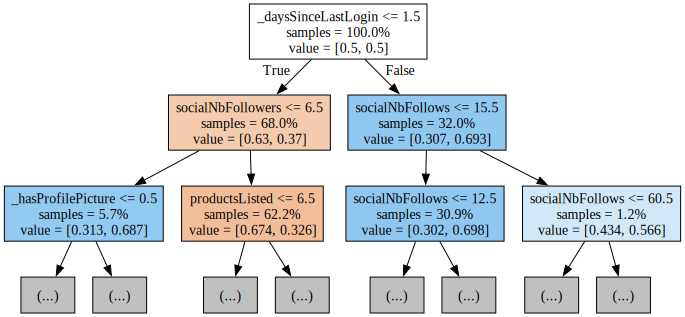

In [22]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Each tree image is limited to only showing the first few nodes. These trees can get very large and difficult to visualize. The colors represent the majority class of each node (box, with red indicating majority 0 (no subscription) and blue indicating majority 1 (subscription). The colors get darker the closer the node gets to being fully 0 or 1. Each node also contains the following information:

The variable name and value used for splitting
The % of total samples in each split
The % split between classes in each split

## 7.2 Evaluation metrics

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

The confusion matrix is a table that shows the number of true positives, true negatives, false positives, and false negatives for a classification model. This plots what the model predicted against what the correct prediction was. We can use this to understand the tradeoff between false positives (top right) and false negatives(bottom left)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

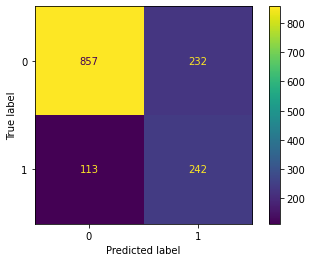

In [25]:
# Generate predictions on second test set with the best model
target_pred2 = rf.predict(feature_test2)

cm = confusion_matrix(target_test2, target_pred2)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

We should also evaluate the best model with accuracy, precision, and recall (note your results may differ due to randomization)

In [26]:
accuracy = accuracy_score(target_test2, target_pred2)
precision = precision_score(target_test2, target_pred2)
recall = recall_score(target_test2, target_pred2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7610803324099723
Precision: 0.510548523206751
Recall: 0.6816901408450704


In [27]:
# Print classification report fortest set
report=classification_report(target_test2, target_pred2, output_dict=True)
pd.DataFrame(report)

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.883505,0.510549,0.76108,0.697027,0.791816
recall,0.786961,0.681690,0.76108,0.734325,0.761080
f1-score,0.832443,0.583836,0.76108,0.708139,0.771324
support,1089.000000,355.000000,0.76108,1444.000000,1444.000000


Now, detecting only 68% (Recall for class 1.0) of frauds may not suffice our actual need, we will find a different route to increase the fraud detection rate further

## 7.3 Visualise important features

The below code plots the importance of each feature, using the model’s internal score to find the best way to split the data within each decision tree. This tells us that the productsSold, socialNbFollowers and productsListed was the biggest predictor in whether the seller is fraudulent.

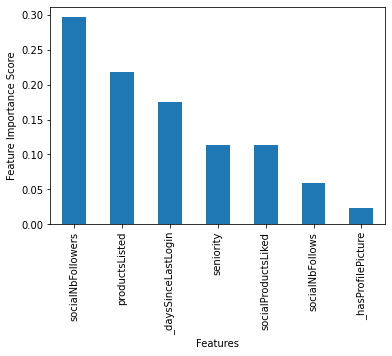

In [28]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=feature_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.show()

# 8. Selecting treshold

As a customer, we may not get harmed by avoiding an innocent seller since sufficient number of sellers would still be there to cater our needs. But, dealing with a fraud is one of the worst nightmares we can ever experience in our life. So, it feels safer to accept a higher number false positives for increasing class 1 Recall.

For this purpose, we can move the probability threshold to a more desired level. Let’s examine the ROC curve for class 1. To identify the optimum threshold, we are going to utilize the first test set preserved earlier.

In [37]:
# get df that stores True Positive Rates and False Positive Rates with corresponding probability thresholds for class 1
target_probabilities = grid.predict_proba(feature_test1)
target_probabilities_class1 = target_probabilities[:,1]
roc_results = roc_curve(target_test1,target_probabilities_class1)
threshold_df = pd.DataFrame()
threshold_df['false_positive_rate'] = roc_results[0]
threshold_df['true_positive_rate'] = roc_results[1]
threshold_df['probability_threshold'] = roc_results[2]

Our motive is to maximize True Positive Rates. So, let’s plot the ROC curve for selecting the suitable threshold value for that.

<IPython.core.display.Javascript object>


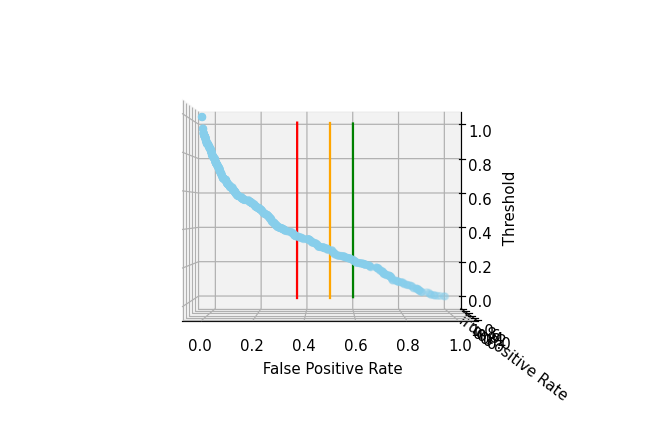

Text(0.5, 0, '\n Threshold')

In [43]:
# creating 3d plot using matplotlib 
 
# for creating a responsive plot
%matplotlib widget

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# creating figure
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(xs=threshold_df['false_positive_rate'][1:],ys=threshold_df['true_positive_rate'][1:],zs=threshold_df['probability_threshold'][1:],color='skyblue')
ax.plot(xs=[0.36,0.36],ys=[0.84,0.88],zs=[0.0,1.0],color='red')[0]
ax.plot(xs=[0.50,0.50],ys=[0.90,0.95],zs=[0.0,1.0],color='orange')[0]
ax.plot(xs=[0.60,0.60],ys=[0.94,0.98],zs=[0.0,1.0],color='green')[0]
ax.set_xlabel('\n False Positive Rate')
ax.set_ylabel('\n True Positive Rate')
ax.set_zlabel('\n Threshold')

To move the probability threshold, we need to check the ROC curve first. The ROC curve contains False Positive Rates (FPR) along the X-axis and True Positive Rates (TPR) along the Y-axis. Here, we need to find a maxima for TPR without increasing the FPR much. In a word, our task is to solve the TPR-FPR trade-off.

Finding the best points on ROC curve is quite subjective and depends on the FPR-aversion of the customer. For that, I have marked three points (notice red, orange and green strikes) on the curve. An individual who is more afraid of getting a false positive, may fix the FPR at around 36% (red strike). But, in that case, the person would be more vulnerable to frauds than people who accepted a higher FPR value (orange and green strikes). From my perspective, I feel comfortable to prefer the green strike as e-commerce sites generally offer plenty of options to buy from.

The preferred treshold is approximately 0.3

In [55]:
# define a function to determine the Recall metric of class 1 for a different test set based on this threshold value
def Recall_Class1(model, Chosen_threshold, feature_test_, target_test_):
    target_probabilities_ = model.predict_proba(feature_test_)
    target_probabilities_class1_ = target_probabilities_[:,1]
    predicted_classlist_ = [1 if i >= Chosen_threshold else 0 for i in target_probabilities_class1_]
    pred_test_ = pd.DataFrame()
    pred_test_['Observed'] = target_test_
    pred_test_['Predicted'] = predicted_classlist_
    predicted_positives = 0
    for i in pred_test_.index:
        if pred_test_.loc[i,'Observed'] == pred_test_.loc[i,'Predicted'] and pred_test_.loc[i,'Observed'] == 1:
            predicted_positives+=1
    total_positives = len(pred_test_[pred_test_['Observed'] == 1.0])
    Recall = predicted_positives/total_positives
    return Recall

In [56]:
Recall_Class1(grid, 0.4, feature_test2, target_test2)

0.7464788732394366

In [57]:
# Model predictions accounting for treshold
def predict_fraud(model, Chosen_threshold, features):
    target_proba = model.predict_proba(features)
    if target_proba[:,1] >= Chosen_threshold:
        target_class = 1
    else:
        target_class = 0
    return target_class

# 9. Implementation

In [66]:
def get_features(a, b, c, d, e, f, g):
    socialNbFollowers = a
    socialNbFollows = b
    socialProductsLiked = c
    productsListed = d
    daysSinceLastLogin = e
    seniority = f
    _hasProfilePicture = g
    features = np.array([[socialNbFollowers, socialNbFollows, socialProductsLiked, productsListed,  daysSinceLastLogin, seniority, _hasProfilePicture]])
    return features

Sus fashion store: https://shopee.sg/ahhj28

In [72]:
feature1 = get_features(1, 116, 0, 4, 35, 2, 1)
rf.predict_proba(feature1)

array([[0.49218374, 0.50781626]])

In [70]:
predict_fraud(rf, 0.4, feature1)

1

Recognised fashion store: https://shopee.sg/lovito.sg

In [75]:
feature2 = get_features(181800, 4, 90000, 10300, 0, 32*30, 1)
rf.predict_proba(feature2)

array([[0.66211779, 0.33788221]])

In [76]:
predict_fraud(rf, 0.4, feature2)

0

Sus phone store: https://shopee.sg/sunmoonman.sg

In [86]:
feature3 = get_features(27, 1, 0, 70, 0, 5*30, 1)
rf.predict_proba(feature3)

array([[0.72882389, 0.27117611]])